<a href="https://colab.research.google.com/github/Sugi1999/Computational-Biology-Projects/blob/main/Machine_Learning_to_Predict_Secondary_Structure_of_Proteins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CSE 163 Final Project**
## Karen Gaffney, Isiac Orr
Section AB - CSE 163

# **User Guide** 
To use this code, first you must download the two data sets found [here](https:/https://www.kaggle.com/tamzidhasan/protein-secondary-sequence/) in addtion to the amino acid propensities .csv provided in the zipped folder. Upload all three files to your google drive. 

The default behavior of this code is to test a ML algorith and a manual algorith of predicting protein secondary structure based on amino acid identity using frame lengths of 2, 4, 6, 8, 10, 12, 14, and 16. The number of sequences tested defaults to 100. The ML algorith is always trained on the full training dataset. Both the number of sequences and frame_lengths tested can be altered in the main method.

The default graphing beahior is to plat all of the manual algorith data first, followed by an mse graph for the ML model.

# **Setup Section**
Here, your google drive is mounted, and as long as all necessary documents from user guide are uploaded to google drive, these methods will set up all libraries and format the data when called from main. 

In [ ]:
! pip install sklearn
from sklearn.tree import DecisionTreeClassifier
from google.colab import drive
from google.colab import files
from IPython.display import HTML
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Importing Kaggle Dataset
def import_kaggle_data(path):
    '''
    Imports kaggle dataset from gdrive
    '''
    kaggle_data = pd.read_csv(path)
    seq = kaggle_data['seq']
    ids = kaggle_data['pdb_id']
    sst = kaggle_data['sst3']
    # formatting
    ids = ids.apply(trim_ids)
    sst = sst.apply(simplify_sst3)
    # combine
    kaggle_data = pd.concat([ids, seq, sst], axis=1)
    return kaggle_data

In [ ]:
def simplify_sst3(ss):
    '''
    Parses through secondary sequence and simplifies to alpha (A) or beta (B)
    Key:
    E = B
    H = A
    B = B
    G = A
    I = A
    C,T,S = V
    '''
    new_sst = ''
    for letter in ss:
        if letter in ['H', 'G', 'I']:
            new_sst += 'A'
        elif letter in ['E', 'B']:
            new_sst += 'B'
        else:
            new_sst += 'V'
    return new_sst

In [ ]:
def trim_ids(id):
    '''
    trim ids to normalize for pypdb module
    '''
    return id[0:-1]  # only keep the first 4 letter/str of each id

In [ ]:
def import_aminoacid_propensites(path):
    aa_prop = pd.read_csv(path)
    aa_prop = aa_prop.reset_index(drop=True)
    return aa_prop

# **Visualization Section**
Here, visualization methods will create graphs from given data when called from main. Only mse_visualizer can be used with ML and manual data. Homogeneity_visualizer runs only on the test data, and accuracy_visualizer runs only with the manual data

In [ ]:
def mse_visualizer(result, label, fig_number):
    '''
    This method takes in mse and frame data from the estimation methods and
    graphs a line graph of mse vs frame
    '''
    plt.figure(fig_number)
    sns.lineplot(x=result['frame'], y=result['mse'], label=label)
    plt.ylim(0, 1)
    plt.title('Mean Squared Error vs Frame Size')
    plt.xlabel('Frame', size=10)
    plt.ylabel('MSE', size=10)
    fig_number += 1
    return fig_number

In [ ]:
def homogeneity_visualizer(full_data, frame_len, fig_number):
    '''
    This method takes in the raw kaggle data and shows how frequent
    homogenous (all A, all B, or all V) frames appear in the true structure
    sequence.
    '''
    for n in frame_len:
        frames = list()
        for index, seq in enumerate(full_data['sst3']):
            length = len(full_data.loc[index, 'sst3'])
            iterations = length // n
            for count, start in enumerate(range(iterations+1)):
                start = start + count * (n - 1)
                frame = seq[start:start+n]
                frames.append(frame)
        frames_df = pd.DataFrame(frames, columns=['Frames'])
        plt.figure(fig_number)
        frame_freq = frames_df.value_counts(normalize=True)[:5]\
            .plot(kind='bar')
        plt.title('Frame Homogeneity in Frame Size = {}'.format(n))
        plt.xlabel('Frame')
        plt.ylabel('Normalized Frequency', size=10)
        fig_number += 1
    return fig_number

In [ ]:
def accuracy_visualization(full_data, fig_number):
    '''
    This figure tkaes in the full data frame and plots the error
    vs sequence length for the manual method. It also takes in a figure number
    and returns a figure number increased by one to keep future generated
    graphs separate. It also takes in a figure number arggument and returns it
    increased by one to create a seperate graphs
    '''
    frames = full_data['frame'].unique()
    for frame_size in frames:
        is_frame = full_data['frame'] == frame_size
        iter_data = full_data[is_frame]
        plt.figure(fig_number)
        frame_size = iter_data['FrameLength'][0]
        iter_data['Seq Length'] = iter_data['Seq Length'].astype(float)
        iter_data['Error'] = iter_data['Error'].astype(float)
        sns.regplot(data=iter_data, x='Seq Length', y='Error')
        plt.title('Error vs Seq Length Frame Size = {}'.format(frame_size))
        plt.xlabel('Sequence Length', size=10)
        plt.ylabel('Error', size=10)
        fig_number += 1

    return fig_number

In [ ]:
def manual_visualizer(simplified_data, full_data, fig_number, frame_len):
    '''
    This method takes in the manually generated data sets and runs the accuracy
    visualizer, homogeneity visualizer, and mse_visualizer
    '''
    fig_number = mse_visualizer(full_data, 'Manual', fig_number)
    fig_number = accuracy_visualization(full_data, fig_number)
    fig_number = homogeneity_visualizer(simplified_data, frame_len, fig_number)
    return fig_number

# **Manual Estimation Section**
Here, these methods compute the predicted secondary structure of the test protein sequences based on the amino acid propensity .csv when called from main.

In [ ]:
def simple_frame(data, size):
    '''
    This method takes in the protein data frame and trims it into the first n
    rows where n is the size argument taken. The simplified dataset is returned
    '''
    df = data.iloc[0:size:1]
    return df

In [ ]:
def manual_structure_estimator(aa_props, kaggle_data,
                               frame_len, a_threshold, b_threshold):
    '''
    This method takes in the propensity dataframe, the protein dataframe, frame
    length, and threshold and uses them to calculate an estimated secondary
    structure sequence which is stored in the created manual_estimate data
    frame. The manual_estimate data frame is returned.
    '''
    manual_estimate = pd.DataFrame(np.empty((len(kaggle_data['seq']), 3),
                                            dtype=np.str),
                                   columns=['Estimate', 'Seq Length', 'frame'])
    for index, seq in enumerate(kaggle_data['seq']):
        length = len(kaggle_data.loc[index, 'seq'])
        iterations = length // frame_len
        for count, start in enumerate(range(iterations+1)):
            a_score = 0
            b_score = 0
            start = start + count * (frame_len - 1)
            frame = seq[start:start+frame_len]
            for aa in frame:
                is_aa = aa_props['aminoacid'] == aa
                scores = aa_props[is_aa]
                a_score += scores.helix.item()
                b_score += scores.strand.item()
            if a_score > a_threshold:
                manual_estimate.loc[index, 'Estimate'] += ('A'*len(frame))
            elif b_score > b_threshold:
                manual_estimate.loc[index, 'Estimate'] += ('B'*len(frame))
            else:
                manual_estimate.loc[index, 'Estimate'] += ('V'*len(frame))
            manual_estimate.loc[index, 'Seq Length'] = length
            manual_estimate.loc[index, 'frame'] = frame_len
    return manual_estimate

In [ ]:
def accuracy_checker(estimate, data):
    '''
    This method takes in an estimate and true data for each secondary structure
    and calculates a percent error. The protein dataframe with an error column
    added on is returned
    '''
    errors = list()
    error_total = 0
    for index, seq in enumerate(data['sst3']):
        est = estimate.loc[index, 'Estimate']
        true = data.loc[index, 'sst3']
        true_seq = data.loc[index, 'seq']
        error = 0
        incorrect_count = 0
        structure_length = len(true)
        for count, structure in enumerate(true):
            if est[count] != structure:
                incorrect_count += 1
        errors.append((incorrect_count)/structure_length)
    data.loc[:, 'Error'] = errors
    return data

In [ ]:
def mse_calculator(data):
    '''
    This method takes in the combined dataset and calculates a mean squared
    error and returns the mean squared error
    '''
    mse = data['Error'].mean()
    #data.loc[:, 'mse'] = (data['Error'] - mse).apply(np.square).apply(np.sqrt)
    data.loc[:, 'mse'] = [math.sqrt(mse**2)] * len(data['Error'])
    return data

In [ ]:
def manual_frame_tester(aa_props, simplified_data, frame_len):
    '''
    This method takes in the propensity data, protein data,
    and a list of frame lengths and runs each of the methods
    used to manually generate a secondary structure sequence
    using each of the framesand returns a full mse dataset for each
    frame length
    '''
    mse_list = list()
    frame_datasets = list()
    for n in frame_len:
        a_threshold, b_threshold = get_parameters(n, aa_props)
        manual_estimate = manual_structure_estimator(aa_props, simplified_data,
                                                     n, a_threshold,
                                                     b_threshold)
        data_with_error = accuracy_checker(manual_estimate, simplified_data)
        full_data = manual_estimate.join(data_with_error)
        full_data.loc[:, 'FrameLength'] = [n]*len(full_data['Error'])
        frame_datasets.append(full_data)
        full_data = mse_calculator(full_data)
    full_dataset = pd.concat(frame_datasets)
    return full_dataset

# **Machine Learning Section**
Here, these methods construct a machine learning model from the training data in main and computes the predicted secondary structure of the sequences in the test data based on the model. 

In [ ]:
def ml_data_prep(data, n, col_names):
    '''
    uses ml classification tree to predict secondary structure of protein
    converts AA code to numeric token, splits in to 7 seq chunks to maintain
    order
    '''
    ml_data = pd.DataFrame()
    # conversion dictionary
    aa_number = {'A': 1, 'R': 2, 'N': 3, 'D': 4, 'B': 5, 'C': 6, 'E': 7,
                 'Q': 8,
                 'Z': 9, 'G': 10, 'H': 11, 'I': 12, 'L': 13, 'K': 14, 'M': 15,
                 'F': 16, 'P': 17, 'S': 18, 'T': 19, 'W': 20, 'Y': 21, 'V': 22,
                 'X': 23}

    # make new normalized dataframe
    seq_chunks = []
    sst_chunks = []
    pdb_id = []
    for row in range(len(data)):
        # split seq in to n res chunks
        seq_chunks = [data.loc[row,
                               'seq'][i:i+n]
                      for i in range(0, len(data.loc[row, 'seq']), n)]
        # splits in to letters
        seq_chunks = [list(chunk) for chunk in seq_chunks]
        for chunk in seq_chunks:
            for count, letter in enumerate(chunk):
                chunk[count] = aa_number[letter]

        # split sst in to n res chunk
        sst_chunk = [data.loc[row, 'sst3'][i:i+n]
                    for i in range(0, len(data.loc[row, 'sst3']), n)]
        sst_chunks.extend(sst_chunk)
        # assign pdb id for all rows
        pdb_id_chunk = list(data.loc[row, 'pdb_id'])
        for x in range(len(sst_chunk)):
            pdb_id.append(data.loc[row, 'pdb_id'])

    # set answer to be most common sst3 in the n res chunk
    seq = pd.DataFrame(seq_chunks, columns=col_names)
    ml_data['sst3'] = sst_chunks
    ml_data['pdb_id'] = pdb_id
    ml_data = pd.concat([ml_data, seq], axis=1, join='inner')
    ml_data = ml_data.dropna()

    return ml_data
  
  


In [ ]:
def ml_structure_estimator_2(train_data, test_data, n, col_names):
    '''
    trains and tests a macine learning structure estimator
    '''
    # the actual machine learning
    features = train_data[col_names]
    labels = train_data['sst3']

    # create an untrained model
    model = DecisionTreeClassifier()
    # train it on our training data
    model.fit(features, labels)

    # the test
    features = test_data[col_names]
    labels = test_data['sst3']
    predictions = model.predict(features)
    test_data['predictions'] = predictions

    return test_data

In [ ]:
def ml_accuracy(test_data):
    '''
    calculates the accuracy of the ml predicitions by residue
    '''
    # accuracy
    # calculate accuract of prediction and group by protein
    mse = []
    total = 0
    correct = 0
    for count, item in enumerate(test_data['predictions']):
        sst3 = test_data.loc[count, 'sst3']
        for count_l, (s_l, i_l) in enumerate(zip(sst3, item)):
            total += 1
            if s_l == i_l:
                correct += 1
        accuracy = 1 - (correct / total)
        mse.append(accuracy)
    test_data['mse'] = mse
    mse_data = test_data.groupby('pdb_id')['mse'].mean()
    
    # calculate mean squared error 
    mse_data = list(mse_data)
    mean_accuracy = np.mean(mse_data)
    mse_data = [(x - mean_accuracy) ** 2 for x in mse_data]
    accuracy = np.sqrt(sum(mse_data))
  
    return [mean_accuracy, accuracy, test_data]

In [ ]:
def generate_col_names(n):
    '''
    generates a list of col names from frame length
    '''
    col_names = []
    for count in range(1, n + 1):
        col_names.append('p' + str(count))
    return col_names

In [ ]:
def ml_pipeline(train_data, test_data, n):
    '''
    implements the ml pipline to go throguh train, test, and accuracy
    '''
    col_names = generate_col_names(n)
    train_data = ml_data_prep(train_data, n, col_names)
    test_data = ml_data_prep(test_data, n, col_names)
    predict_data = ml_structure_estimator_2(train_data, test_data, n,
                                            col_names)
    return ml_accuracy(predict_data)

In [ ]:
def ml_frame(train_data, test_data, n):
    '''
    implements the ml pipeline and accuracy for a list of frames
    '''
    stats = []
    mse = []
    for frame in n:
        accuracy = ml_pipeline(train_data, test_data, frame)
        mean_acc = accuracy[0]
        error = accuracy[1]
        mse_data = accuracy[2]
        frame = [str(frame) for x in range(len(mse_data))]
        mse_data['frame'] = frame
        stats.append((mean_acc, error))
        mse.append(mse_data)
    return mse


# **Main Method Section**
Here, all previous methods are called, and size and frame lengths are set. 

In [ ]:
def get_parameters(frame_len, aa_props):
    '''
    This method takes in the amino acid propensity dataframe and a frame length
    and calculates the trheshold for the manual estimater to determine
    A, B, or V
    '''
    a_mean = aa_props['helix'].mean()
    a_std = aa_props['helix'].std()
    b_mean = aa_props['strand'].mean()
    b_std = aa_props['strand'].std()

    a_threshold = a_mean * frame_len + a_std
    b_threshold = b_mean * frame_len + b_std

    return (a_threshold), (b_threshold)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

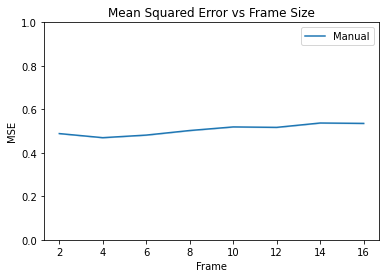

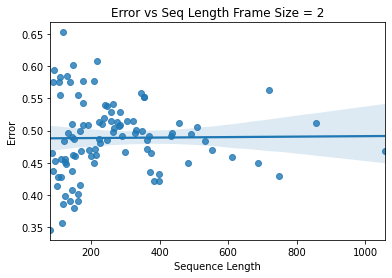

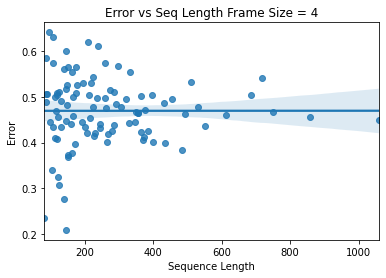

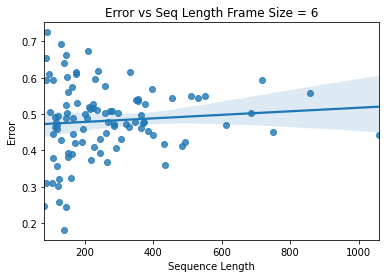

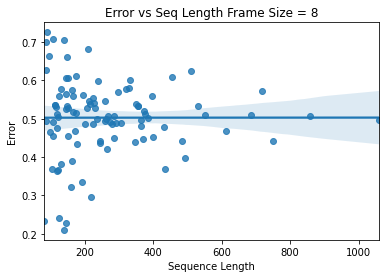

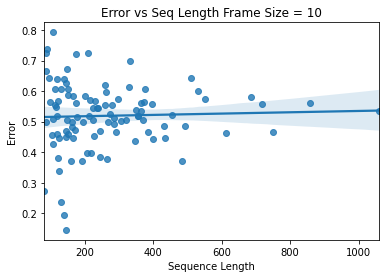

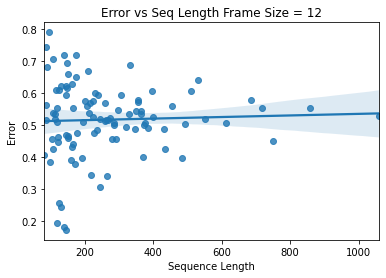

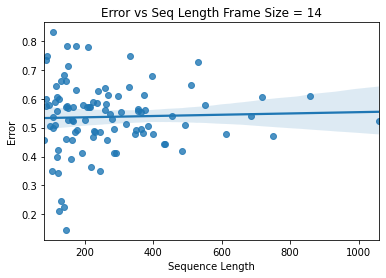

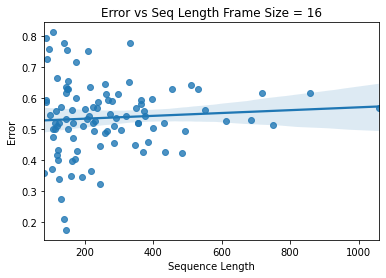

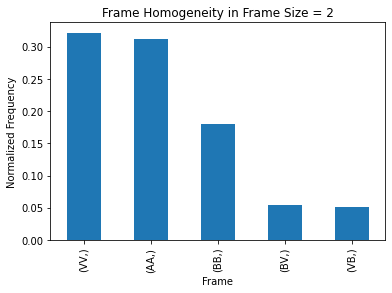

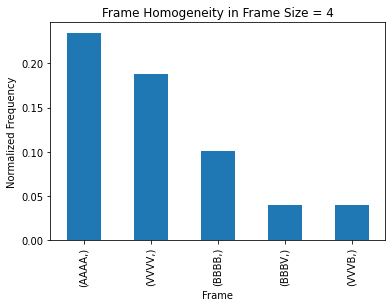

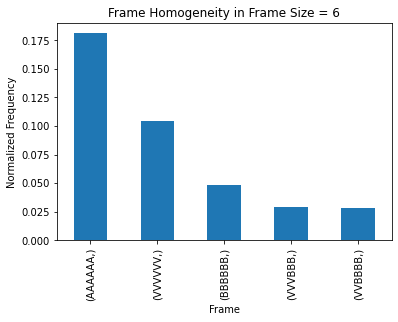

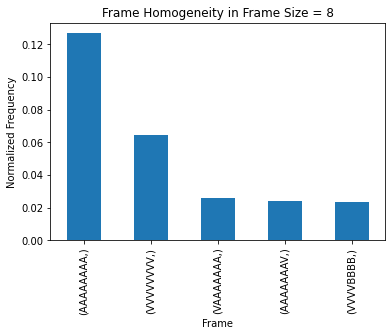

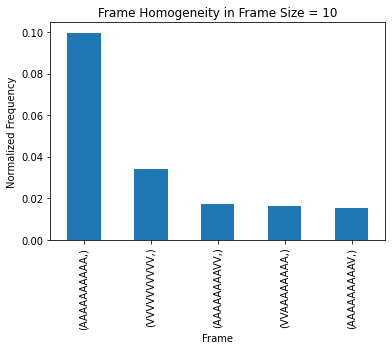

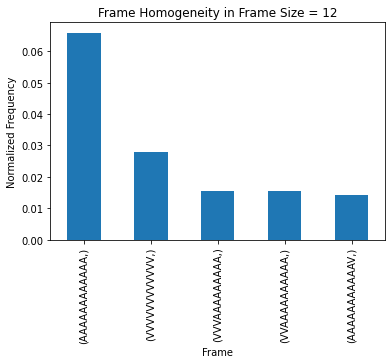

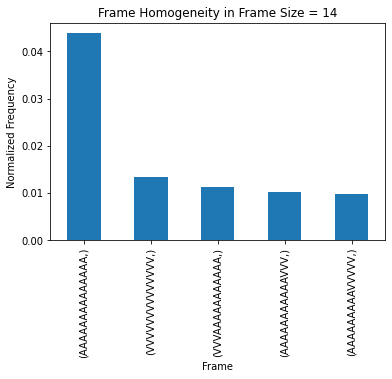

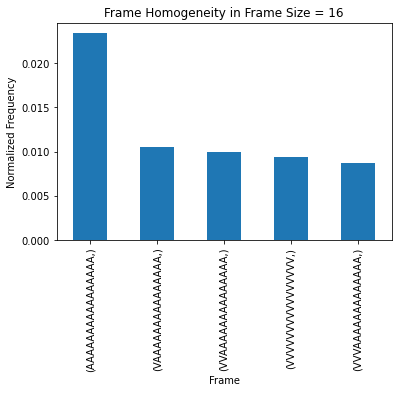

In [ ]:
def main():
    test = '/content/gdrive/My Drive/PDB_31-12-2012.csv'
    train = '/content/gdrive/My Drive/PDB_31-07-2011.csv'
    aa = '/content/gdrive/My Drive/AminoAcidPropensities.csv'
    test_data = import_kaggle_data(test)
    train_data = import_kaggle_data(train)
    aa_props = import_aminoacid_propensites(aa)


    # Enter frame number here
    frame_len = [2, 4, 6, 8, 10, 12, 14, 16]

    # Enter dataset size here (every 100 sequences = ~2 min)
    size = 100

    # ML work
    #mse = ml_frame(train_data, test_data.iloc[:size, :], frame_len)
    # returns mean accuracy and mean squared error of each frame size
    #ml_result = pd.concat(mse)

    # Manual Work
    fig_number = 1
    simplified_data = simple_frame(test_data, size)
    full_dataset = manual_frame_tester(aa_props, simplified_data, frame_len)

    fig_number = manual_visualizer(simplified_data, full_dataset,
                                   fig_number, frame_len)

    #mse_visualizer(ml_result, 'ML', fig_number)


if __name__ == '__main__':
    main()